In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [27]:
# 1. Загрузка данных
df = pd.read_csv('Microsoft_stock_data.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

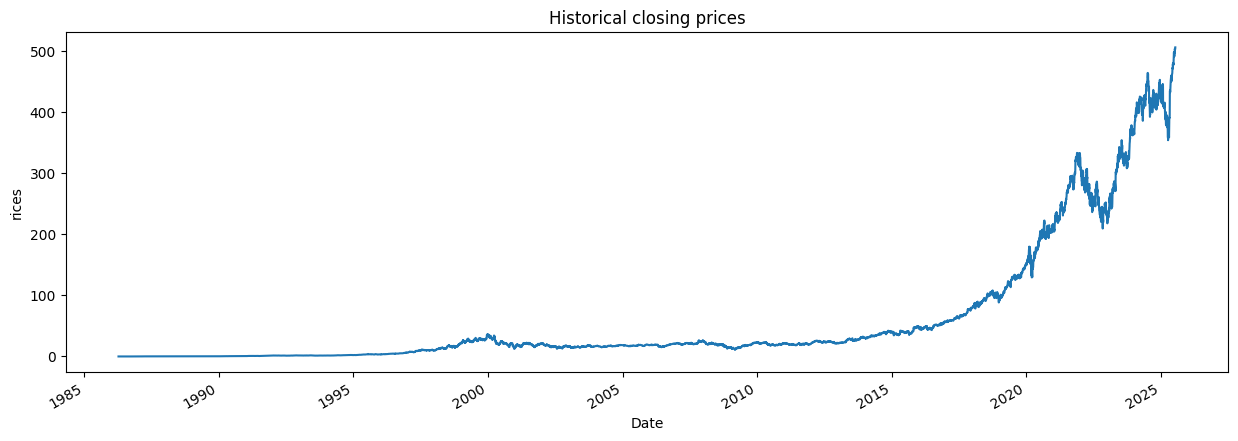

In [34]:
df['Close'].plot(figsize=(15, 5), title='Historical closing prices')
plt.ylabel('rices')
plt.show()

In [28]:
# 2. Генерация новых признаков
df['Range'] = df['High'] - df['Low']
df['Close_Open_Ratio'] = df['Close'] / df['Open']
for window in [5, 10, 20]:
    df[f'SMA_{window}'] = df['Close'].rolling(window).mean()
df.dropna(inplace=True)

# 3. Масштабирование
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Close', 'Range', 'Close_Open_Ratio', 'SMA_5', 'SMA_10', 'SMA_20', 'Volume']])


In [29]:
# 4. Создание последовательностей
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 1:])  # все признаки, кроме Close (т.к. Close в y)
        y.append(data[i+seq_length, 0])     # Close
    return np.array(X), np.array(y)

SEQ_LEN = 30
X, y = create_sequences(scaled, SEQ_LEN)

In [30]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(50, input_shape=(SEQ_LEN, X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

e:\Alex\Anaconda\envs\tf_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 30, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 6.1209e-04 - val_loss: 1.3068e-04
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.8051e-05 - val_loss: 1.2560e-05
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.9778e-05 - val_loss: 1.3108e-05
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.3333e-05 - val_loss: 1.0789e-05
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.7545e-05 - val_loss: 1.2147e-05
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.4492e-05 - val_loss: 1.4808e-05
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.2193e-05 - val_loss: 1.3061e-05
Epoch 8/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.1684e-05 - val_loss: 1.2848e-05
Epoch 9/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.0179e-05 - val_loss: 1.0237e-05
Epoch 10/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 9.3710e-06 - val_loss: 1.2950e-05
Epoch 11/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/

In [32]:
y_pred = model.predict(X_test)
# Восстановим масштаб Close
def inverse_close(scaled_close, seq_feats):
    return scaler.inverse_transform(
        np.hstack((scaled_close.reshape(-1,1), seq_feats))
    )[:, 0]

last_feats = X_test[:, -1, :]
y_test_inv = inverse_close(y_test, last_feats)
y_pred_inv = inverse_close(y_pred.flatten(), last_feats)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


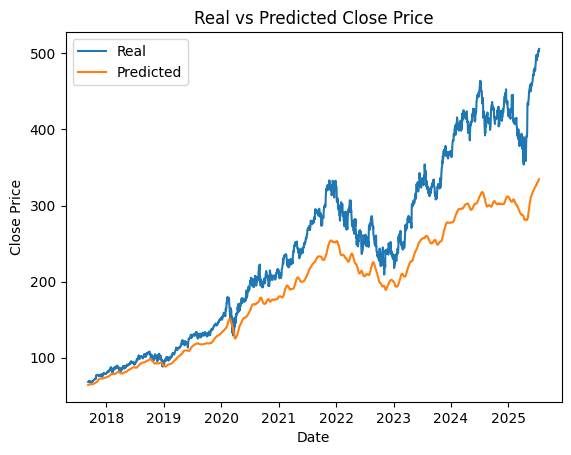

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 30

In [33]:
plt.figure()
plt.plot(df.index[-len(y_test):], y_test_inv, label='Real')
plt.plot(df.index[-len(y_pred):], y_pred_inv, label='Predicted')
plt.title('Real vs Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# 10. Предсказание на следующий день
last_seq = scaled[-SEQ_LEN:, 1:]
last_seq = last_seq.reshape((1, SEQ_LEN, X.shape[2]))
next_scaled = model.predict(last_seq)
next_price = inverse_close(next_scaled.flatten(), last_seq[0])
print(f"Predicted next day Close price: {next_price:.4f}")